In [ ]:
# First training results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA
import sys
from sklearn.decomposition import PCA
#sys.path.insert(0, "/Users/mbornhol/git/neural-profiling")

In [2]:
df = pd.read_csv('806_aggregated_median.csv', low_memory=False)

In [3]:
df_meta = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/data-prep/02_index_preperation/repurposing_info_external_moa_map_resolved.tsv', sep='\t')
df_meta = df_meta[['broad_sample', 'moa']]
df_meta.rename(columns = {'broad_sample' : 'Metadata_broad_sample', 'moa' : 'Metadata_moa'}, inplace=True)

In [4]:
features = [f for f in df.columns if f.startswith('eff')]
meta_features = [feat for feat in df.columns if feat not in features]
top_moa = df.Metadata_moa.value_counts()[1:20].keys().tolist()

In [5]:
k_range = [5, 10, 15, 20, 25]
p_range = np.arange(0.995, 0.96, -0.005)

Explained variation per principal component: [0.70451489 0.13392863 0.03099215]


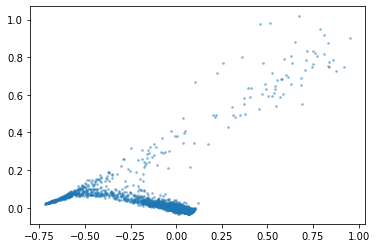

In [7]:
def pca_plot(df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[features].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.style.use({'figure.facecolor':'white'})
    plt.scatter(df['pca-one'], df['pca-two'], s = 3, alpha= 0.4)
    plt.show()
pca_plot(df)

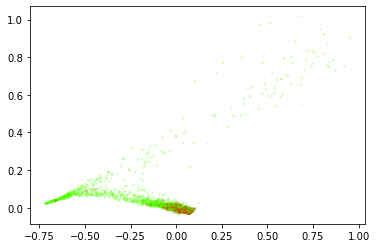

In [8]:
def is_dmso(sample):
    if sample == 'DMSO':
        return 0
    else:
        return 1
df = df.sample(frac=1).reset_index(drop=True)
df['color'] = df.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(df['pca-one'], df['pca-two'], c = df['color'], marker= 'o', s = 2, alpha= 0.2, cmap = 'prism')
plt.show()

In [8]:
normed = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)

sphere = normalize(
    profiles=normed,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)

In [9]:
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)

In [10]:
con = pd.merge(con, df_meta, how='left', on=['Metadata_broad_sample'])
res_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p_range
    )
res_sphere

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.405798,5.186674,1.220933e-89
1,0.990,0.219857,3.758947,2.472457e-91
2,0.985,0.149424,3.105100,5.195790e-87
3,0.980,0.118036,2.604037,3.720019e-73
4,0.975,0.104204,2.269523,4.881526e-61
5,0.970,0.095608,2.069807,4.227563e-54
6,0.965,0.089783,1.934094,1.976787e-49
7,0.960,0.085076,1.809991,1.036213e-43


In [12]:
res_sphere.to_csv('806_enrichment.csv')

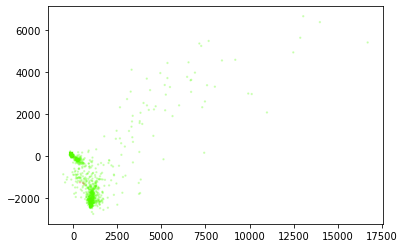

In [42]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sphere[features].values)
sphere['pca-one'] = pca_result[:,0]
sphere['pca-two'] = pca_result[:,1]
sphere['color'] = sphere.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 0.2, cmap = 'prism')
plt.show()


In [65]:
%matplotlib qt
comp = sphere['Metadata_broad_sample'].unique()[:5]
def comps(row):
    if row in comp:
        return list(comp).index(row)
    else:
        return 0
sphere['color2'] = sphere.Metadata_broad_sample.apply(comps)
sphere = sphere.sort_values(by = ['color2'], ascending=True)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color2'], marker= 'o', s = 2, alpha= 0.7)
plt.xlim(-1000, 2000)
plt.ylim(-2500, 1000)
plt.show()